# Price Regresion Problem and Black Box Model Analiz
- In this project, efforts have been made to perform tasks ranging from data processing to building a model, refining the model, and finally, conducting data analysis by retracing the model.

- Machine learning models, undoubtedly, brilliant in capturing more complex relationships compared to classical statistical forecasting models, and they operate with less reliance on data simulation. They are not affected by conditions such as autocorrelation. However, when it comes to data analysis, these models are like black boxes and are much less straightforward in delivering efficient results compared to classical statistical models.

- Among various methods, I chose the Partial Dependence method, which can be considered faster in application speed and more successful in terms of stability. I visualized the impact of data exceeding the price in a model-dependent way.

- Finally, the reason for the magnitude of the modeling part in this study is that the more successful the model is, the more reliable and stable the effects become.


### Importing Libraries

In [261]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',80)
import scipy.stats as sts
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler,RobustScaler,LabelEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, mean_absolute_error

from tqdm import tqdm
import optuna
import joblib
import time

from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,VotingRegressor

from sklearn.inspection import PartialDependenceDisplay

### My Functions and Classes

In [20]:
def resumtable(df):
    print(f'Data Shape:{df.shape}')
    num_df=df.select_dtypes(include='number')
    num_summary=pd.DataFrame(num_df.dtypes,columns=['dtypes'])
    num_summary=num_summary.reset_index()
    num_summary['Name']=num_summary['index']
    num_summary=num_summary[['Name','dtypes']]
    num_summary['Missing']      =num_df.isnull().sum().to_list()
    num_summary['Uniques']      =num_df.nunique().values
    num_summary['First Values'] =num_df.loc[0].values
    num_summary['Second Values']=num_df.loc[1].values 
    num_summary['Third Values'] =num_df.loc[2].values
    num_summary['Mean']         =[num_df[i].mean() for i in num_df.columns]
    num_summary['Min']          =[num_df[i].min() for i in num_df.columns]
    num_summary['25%']          =[num_df[i].quantile(0.25) for i in num_df.columns]
    num_summary['50%']          =[num_df[i].quantile(0.50) for i in num_df.columns]
    num_summary['75%']          =[num_df[i].quantile(0.75) for i in num_df.columns]
    num_summary['Max']          =[num_df[i].max() for i in num_df.columns]
    num_summary['std']          =[num_df[i].std() for i in num_df.columns]

    for name in num_summary['Name'].value_counts().index:
        num_summary.loc[num_summary['Name']==name, 'Entropy']=round(
            sts.entropy(df[name].value_counts(normalize=True),base=2),2)
        

    cat_df=df.select_dtypes(exclude='number')
    cat_summary=pd.DataFrame(cat_df.dtypes,columns=['dtypes'])
    cat_summary=cat_summary.reset_index()
    cat_summary['Name']=cat_summary['index']
    cat_summary=cat_summary[['Name','dtypes']]
    cat_summary['Missing']      =cat_df.isnull().sum().to_list()
    cat_summary['Uniques']      =cat_df.nunique().values
    cat_summary['First Values'] =cat_df.loc[0].values
    cat_summary['Second Values']=cat_df.loc[1].values 
    cat_summary['Third Values'] =cat_df.loc[2].values
    cat_summary['Min']          =[cat_df[i].value_counts().index[-1] for i in cat_df.columns]
    cat_summary['Min Freq']     =[cat_df[i].value_counts()[-1] for i in cat_df.columns]
    a25=[]
    b50=[]
    c75=[]
    afrq=[]
    bfrq=[]
    cfrq=[]
    for c,i in enumerate(cat_df.columns):
        a=np.round(((len(cat_df[[i]].value_counts())*0.75)),0)
        b=np.round(((len(cat_df[[i]].value_counts())*0.5)),0)
        c=np.round(((len(cat_df[[i]].value_counts())*0.25)),0)
        afrq.append(cat_df[i].value_counts().reset_index().iloc[int(a),1])
        bfrq.append(cat_df[i].value_counts().reset_index().iloc[int(b),1])
        cfrq.append(cat_df[i].value_counts().reset_index().iloc[int(c),1])
        a25.append(cat_df[i].value_counts().index[int(a)])
        b50.append(cat_df[i].value_counts().index[int(b)])
        c75.append(cat_df[i].value_counts().index[int(c)])

    cat_summary['25%']          =[i for i in a25]
    cat_summary['25% Freq']     =[i for i in afrq]
    cat_summary['50%']          =[i for i in b50]
    cat_summary['50% Freq']     =[i for i in bfrq]
    cat_summary['75%']          =[i for i in c75] 
    cat_summary['75% Freq']     =[i for i in cfrq]
    cat_summary['Mode']         =[cat_df[i].mode()[0] for i in cat_df.columns]
    cat_summary['Mode Freq']    =[cat_df[i].value_counts()[0] for i in cat_df.columns]
    for name in cat_summary['Name'].value_counts().index:
        cat_summary.loc[cat_summary['Name']==name, 'Entropy']=round(
            sts.entropy(df[name].value_counts(normalize=True),base=2),2)
    
    return num_summary, cat_summary
    del a25, a50,a75,afrq,bfrq,cfrq,c,i

In [24]:
def dist_graper(df,col_names,num_rows,num_cols,dpi=125,log=False):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*7, num_cols*5), dpi=dpi,)

    if log:
        for i, col in enumerate(col_names):
            row_index=i//num_cols
            col_index=i%num_cols
            ax=axes[row_index,col_index]
            a=df[col].copy()
            a.loc[a==0]=0.01
            a=np.log(a)
            (mu,sigma)=sts.norm.fit(a)
            (stat,p)=sts.normaltest(a)
            g=sns.histplot(x=a,kde=True,ax=ax,label='Dist $\mu=$ {:.2f} and $\sigma=$ {:.2f}\nNormality Stat= {:.2f} and P-value= {:.2f}'.format(mu, sigma, stat, p))
            g.set_title(f'{col.capitalize()} Distribution',fontsize=22)
            g.set_xlabel(f'{col.capitalize()} Distribution',fontsize=18)
            g.set_ylabel('Count ',fontsize=18)
            mean_val = np.mean(a)
            median_val = np.median(a)
            mode_val = sts.mode([a])[0][0]
            g.axvline(x=mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
            g.axvline(x=median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
            g.axvline(x=mode_val, color='b', linestyle='--', label=f'Mode: {mode_val:.2f}')
        
            g.legend()
    
        for i in range(len(col_names), num_rows * num_cols):
            row_index = i // num_cols
            col_index = i % num_cols
            fig.delaxes(axes[row_index, col_index])
            del a
    else:
        for i, col in enumerate(col_names):
            row_index=i//num_cols
            col_index=i%num_cols
            ax=axes[row_index,col_index]

            (mu,sigma)=sts.norm.fit(df[col])
            (stat,p)=sts.normaltest(df[col])
            g=sns.histplot(x=col,data=df,kde=True,ax=ax,label='Dist $\mu=$ {:.2f} and $\sigma=$ {:.2f}\nNormality Stat= {:.2f} and P-value= {:.2f}'.format(mu, sigma, stat, p))
            g.set_title(f'{col.capitalize()} Distribution',fontsize=22)
            g.set_xlabel(f'{col.capitalize()} Distribution',fontsize=18)
            g.set_ylabel('Count ',fontsize=18)
            mean_val = np.mean(df[col])
            median_val = np.median(df[col])
            mode_val = df[col].mode()[0]

            g.axvline(x=mean_val,  color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
            g.axvline(x=median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
            g.axvline(x=mode_val, color='b', linestyle='--', label=f'Mode: {mode_val:.2f}')

            g.legend()

        for i in range(len(col_names), num_rows * num_cols):
            row_index = i // num_cols
            col_index = i % num_cols
            fig.delaxes(axes[row_index, col_index])


   
    plt.tight_layout()
    plt.show()
    del g,mean_val,median_val,mode_val,i,col,row_index,col_index,fig,axes,ax

In [27]:
def Outliers_Fighter(df_cols,df,cut_level=3,kill=False):
    tmp=pd.DataFrame(columns=df_cols,index=['Lower Bound:','Upper Bound',
                                            'Identified lowest outliers',
                                            'Identified upper outliers',
                                            'Total outlier observations',
                                            'Non-outlier observations:',
                                            'Total percentual of Outliers'])

    before=len(df)
    for i,col in enumerate(df_cols):
        data_mean, data_std = np.mean(df[col]), np.std(df[col])
        cut=data_std*cut_level
        lower, upper=data_mean-cut,data_mean+cut

        tmp.iloc[0,i]=np.round(lower,2)#lower_bound
        tmp.iloc[1,i]=np.round(upper,2)#upper_bound
        tmp.iloc[2,i]=len([x for x in df[col] if x < lower])#outliers_lower
        tmp.iloc[3,i]=len([x for x in df[col] if x > upper])#outliers_upper  
        tmp.iloc[4,i]=len([x for x in df[col] if x < lower or x > upper])#outliers_total
        tmp.iloc[5,i]=len([x for x in df[col] if x > lower and x < upper])#outliers_removed
        tmp.iloc[6,i]=np.round((tmp.iloc[4,i]/tmp.iloc[5,i]),4)
        if kill:
            df=df.loc[(df[col] > lower) & (df[col] < upper)]
    after=len(df)
    if kill:
        print(f'Total lose ratio of data: {np.round((after/before),3)}')
    
    return df,tmp
    del after,before,tmp,kill

In [212]:
def manipulator(df):
    df.loc[df.year<2010,'year']=2009
    df=df[df.price<=50000]
    df.loc[df.transmission=='Other','transmission']='Manual'
    df.loc[df.mileage>=90000,'mileage']=90000
    df.loc[(df.fuelType=='Other')|(df.fuelType=='Electric'),'fuelType']=='Petrol'
    df.loc[df.tax>=310,'tax']=310
    df.loc[df.tax<=10,'tax']=10
    df.loc[df.mpg>=100,'mpg']=110
    df.loc[df.engineSize>=4,'engineSize']=4
    df.loc[(df.engineSize==3.5) ,'engineSize']=4
    df.loc[(df.engineSize==3.2),'engineSize']=3
    df.loc[(df.engineSize==2.9),'engineSize']=3
    df.loc[(df.engineSize==2.8),'engineSize']=2.5
    df.loc[(df.engineSize==2.7),'engineSize']=2.5
    df.loc[(df.engineSize==2.4),'engineSize']=2.5
    df.loc[(df.engineSize==2.3),'engineSize']=2.5
    df.loc[(df.engineSize==2.2),'engineSize']=2.5
    df.loc[(df.engineSize==1.7),'engineSize']=1.9
    df.loc[(df.engineSize==1.3),'engineSize']=1.2
    df.loc[(df.engineSize==1.1),'engineSize']=1.2
    df.loc[(df.engineSize==0.6),'engineSize']=1
    a=df.model.value_counts()[df.model.value_counts()<100].index
    df['model'] = df['model'].apply(lambda x: 'Other' if x in a else x)
    return df

In [33]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns 


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [34]:
class MultiColumnScaler:

    def __init__(self, columns=None):
        self.columns = columns 


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = RobustScaler().fit(X[col].to_numpy().reshape(-1,1))
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col].to_numpy().reshape(-1,1))
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col].to_numpy().reshape(-1,1))
        return output

In [187]:
class model_factory:
    def __init__(self,x_tr,x_ts,y_tr,y_ts,models):
        self.x_tr=x_tr
        self.x_ts=x_ts    
        self.y_tr=y_tr
        self.y_ts=y_ts
        self.models=models
        
    def fit_and_pred(self,scorer):
        self.result = {'Model':[],'Score':[]}

        
        for model in self.models:
            model.fit(self.x_tr,self.y_tr)
            y_pr = model.predict(self.x_ts)
            score = np.round(scorer(self.y_ts, y_pr),3)

            self.result['Model'].append(model.__class__.__name__)
            self.result['Score'].append(score)

    def get_result_df(self):
        scores_df = pd.DataFrame(self.result)
        scores_df = scores_df
        scores_df = scores_df.sort_values(by='Score').reset_index().drop('index',axis=1)
        return scores_df
                   

In [221]:
class find_best_way():

    def __init__(self,cat_col,num_col,x,y,x_tr,y_tr):
        self.cat_col=cat_col
        self.num_col=num_col
        self.x=x
        self.y=y
        self.x_tr=x_tr
        self.y_tr=y_tr
        self.result={
            'Model': [],
            'Scaler': [],
            'Encoder': [],
            'Score': [],
            'Score_Std': []
        }


    def lay_the_pipeline(self,model,scaler,encoder,cv=5,scoring='neg_root_mean_squared_error'):
        self.model=model
        self.scaler=scaler
        self.encoder=encoder
        num_transformer = make_pipeline(self.scaler)
        cat_transformer = make_pipeline(self.encoder)
        preprocessor = ColumnTransformer(
            transformers = [('num', num_transformer, self.num_col),
                        ('cat', cat_transformer, self.cat_col)],
                        remainder='passthrough'
        
        )

        self.preprocessor=preprocessor
        pipe = make_pipeline(self.preprocessor,self.model)
        self.pipe=pipe
        self.pipe.fit(self.x_tr,self.y_tr)
        scores=cross_val_score(self.pipe, self.x, self.y, cv=cv, scoring=scoring)
        self.result['Model'].append(self.model.__class__.__name__)
        self.result['Scaler'].append(self.scaler.__class__.__name__)
        self.result['Encoder'].append(self.encoder.__class__.__name__)
        self.result['Score'].append(np.round( -scores.mean(),3 ))    
        self.result['Score_Std'].append(np.round( scores.std(),3 ))    
        
    def get_result_df(self):
        result_df=pd.DataFrame(self.result).sort_values(by='Score').reset_index().drop('index',axis=1)
        return result_df
        del self.result
    


In [264]:
def pdp_graper(model,df,col_names,cat_col,heigth,width,dpi=175):
    g=PartialDependenceDisplay.from_estimator(model, df, features=col_names,categorical_features=cat_col, grid_resolution=300,n_jobs=-1)
    g.figure_.set_figheight(heigth)
    g.figure_.set_figwidth(width)
    g.figure_.dpi=dpi
    plt.tight_layout()
    plt.show()

## 1) First Look and Data analazing  

### A) First Look

In [16]:
df=pd.read_csv('cars_dataset.csv')

In [17]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
72430,I30,2016,8680,Manual,25906,Diesel,0.0,78.4,1.6,Hyundai
72431,I40,2015,7830,Manual,59508,Diesel,30.0,65.7,1.7,Hyundai
72432,I10,2017,6830,Manual,13810,Petrol,20.0,60.1,1.0,Hyundai
72433,Tucson,2018,13994,Manual,23313,Petrol,145.0,44.8,1.6,Hyundai


In [21]:
df_num,df_cat=resumtable(df)

Data Shape:(72435, 10)


In [22]:
df_num

,Name,dtypes,Missing,Uniques,First Values,Second Values,Third Values,Mean,Min,25%,50%,75%,Max,std,Entropy
0,year,int64,0,25,2017.0,2016.0,2016.0,2017.073666,1996.0,2016.0,2017.0,2019.0,2020.0,2.101252,2.83
1,price,int64,0,10418,12500.0,16500.0,11000.0,16580.158708,495.0,10175.0,14495.0,20361.0,145000.0,9299.028754,11.14
2,mileage,int64,0,35743,15735.0,36203.0,29946.0,23176.517057,1.0,7202.5,17531.0,32449.0,323000.0,21331.515562,14.24
3,tax,float64,0,47,150.0,20.0,30.0,116.953407,0.0,30.0,145.0,145.0,580.0,64.045533,2.67
4,mpg,float64,0,177,55.4,64.2,55.4,55.852480,0.3,47.9,55.4,62.8,470.8,17.114391,5.66
5,engineSize,float64,0,32,1.4,2.0,1.4,1.635650,0.0,1.2,1.6,2.0,6.6,0.561535,2.90


In [23]:
df_cat

,Name,dtypes,Missing,Uniques,First Values,Second Values,Third Values,Min,Min Freq,25%,25% Freq,50%,50% Freq,75%,75% Freq,Mode,Mode Freq,Entropy
0,model,object,0,146,A1,A6,A1,Amica,1,M3,27,M4,125,Mondeo,526,Fiesta,6556,5.76
1,transmission,object,0,4,Manual,Automatic,Manual,Other,4,Other,4,Automatic,14046,Semi-Auto,15364,Manual,43021,1.38
2,fuelType,object,0,5,Petrol,Diesel,Petrol,Electric,5,Electric,5,Hybrid,2903,Diesel,28918,Petrol,40370,1.21
3,Make,object,0,7,audi,audi,audi,Hyundai,4860,skoda,6267,toyota,6738,BMW,10781,Ford,17964,2.67


### B) Veraible Analize

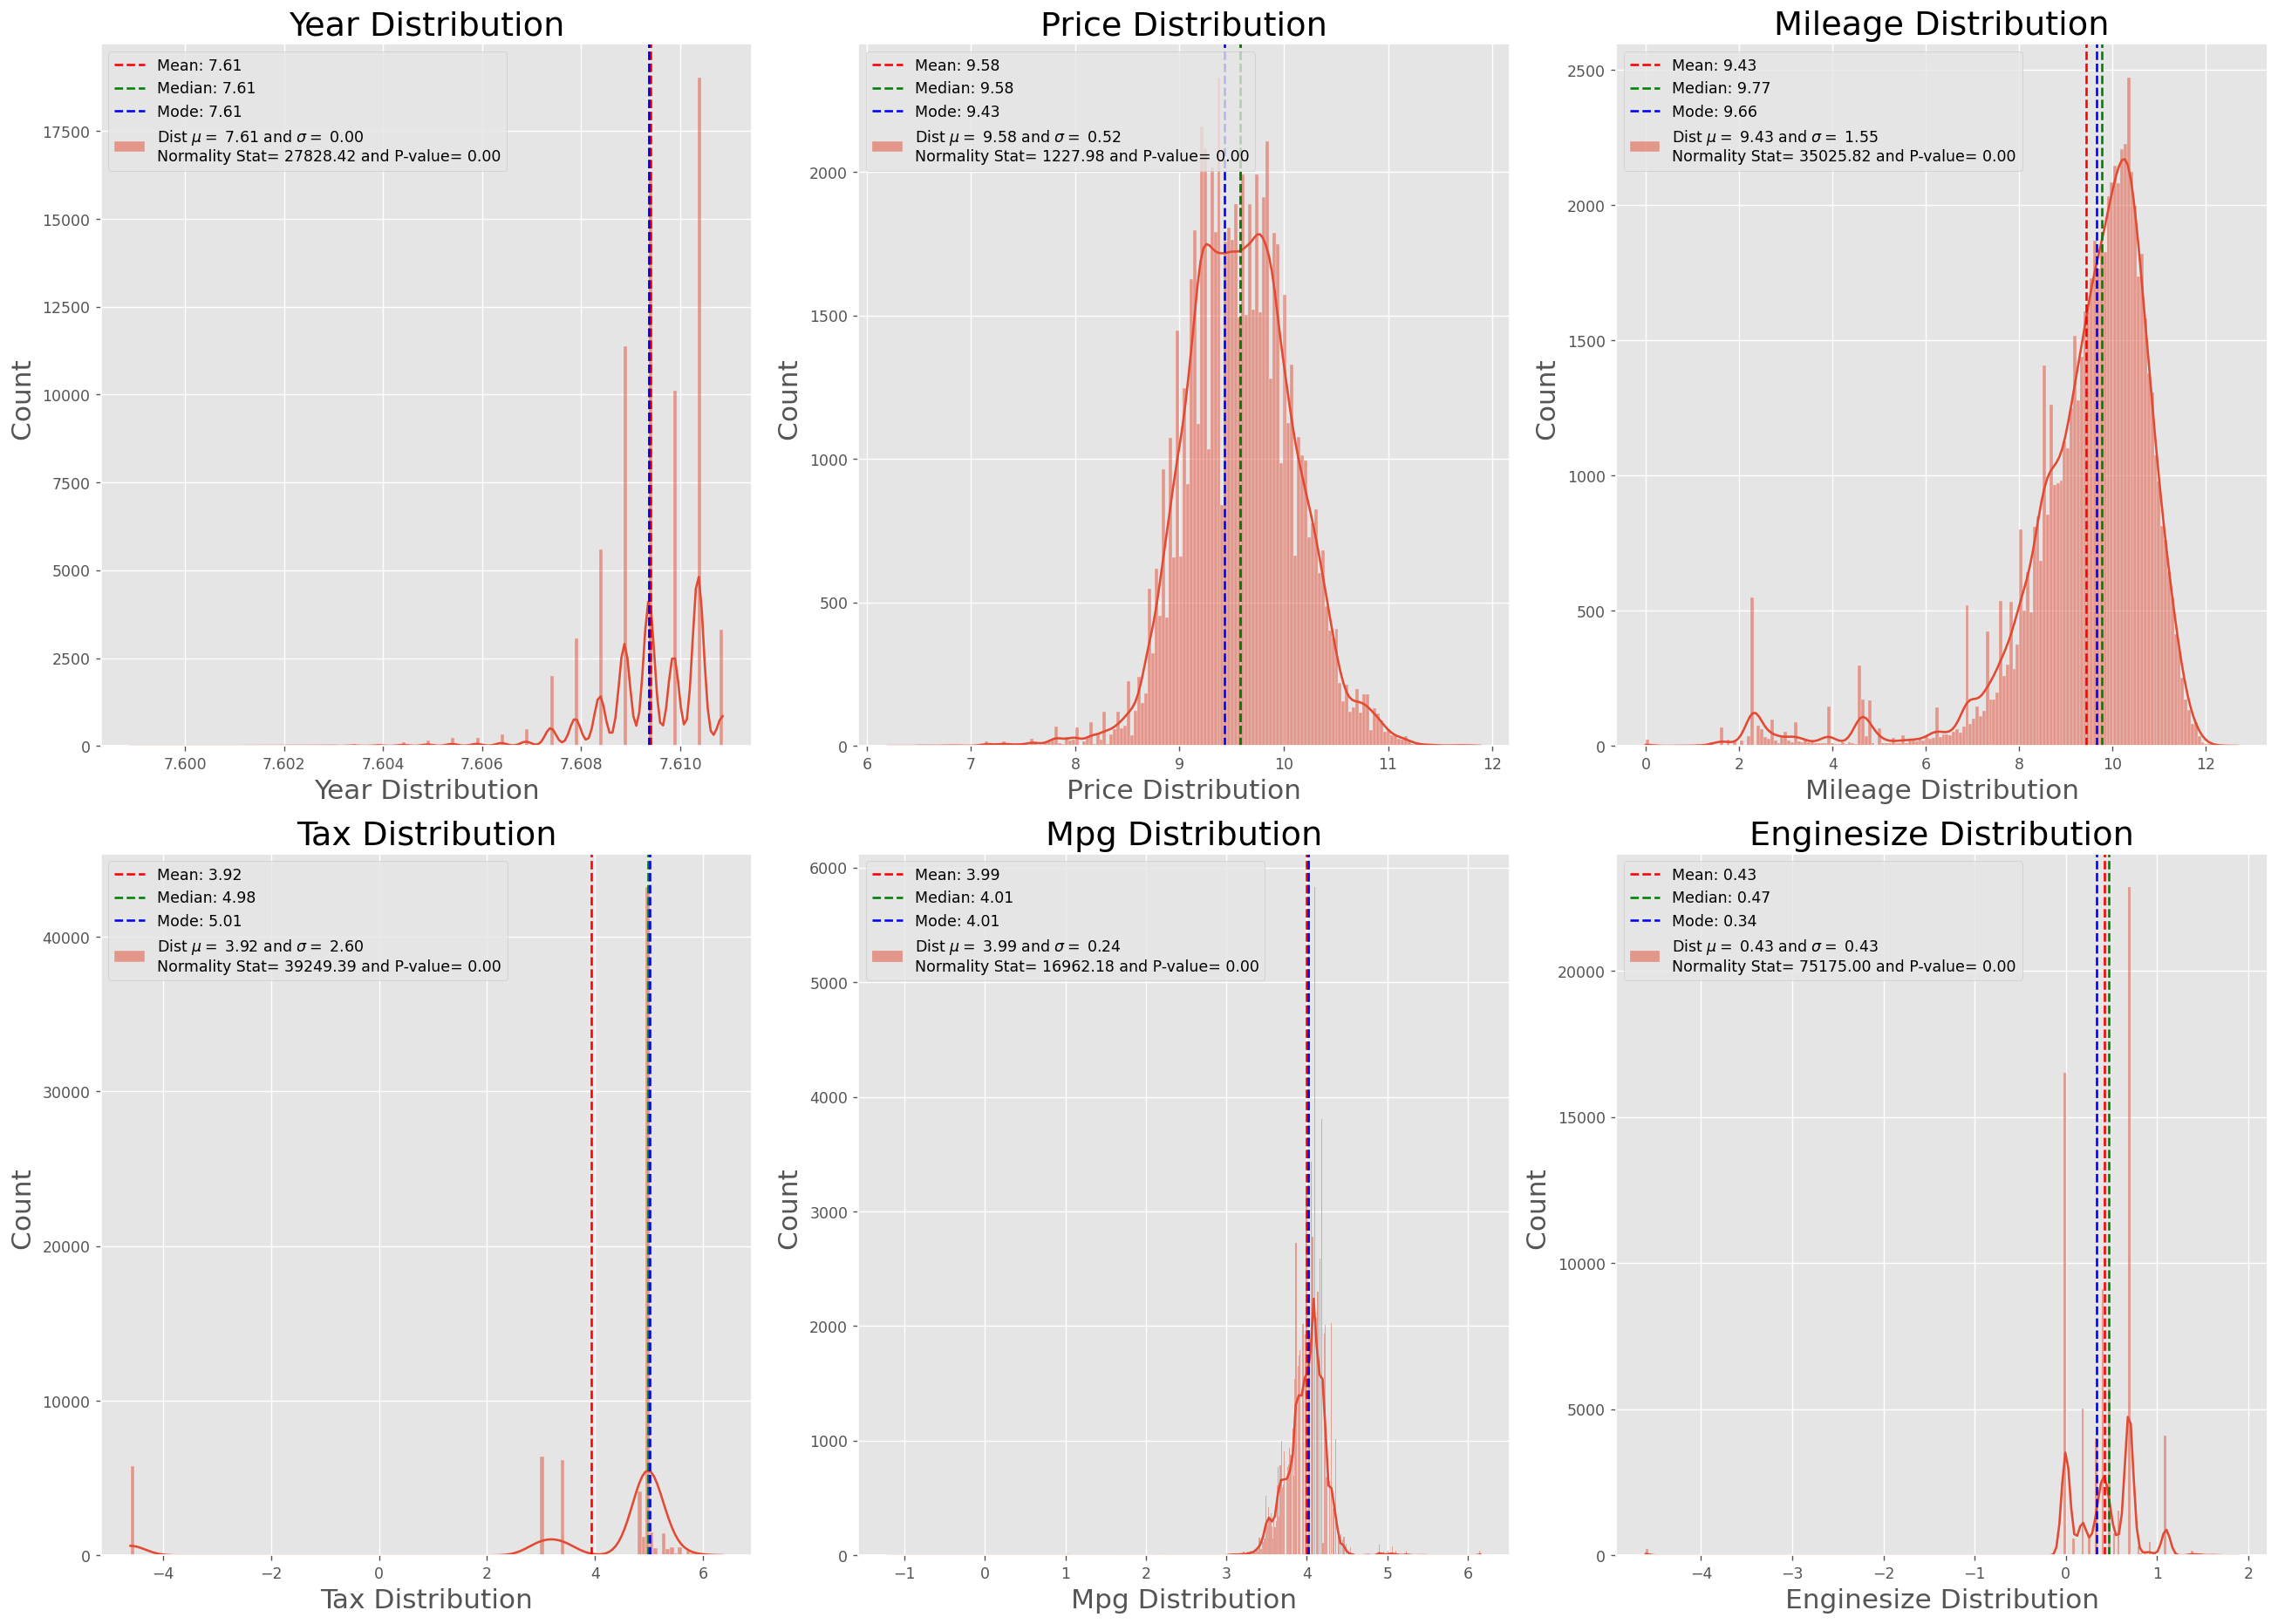

In [25]:
col_names=[i for i in df.select_dtypes(exclude=['object'])]
dist_graper(df,col_names,2,3,log=True)

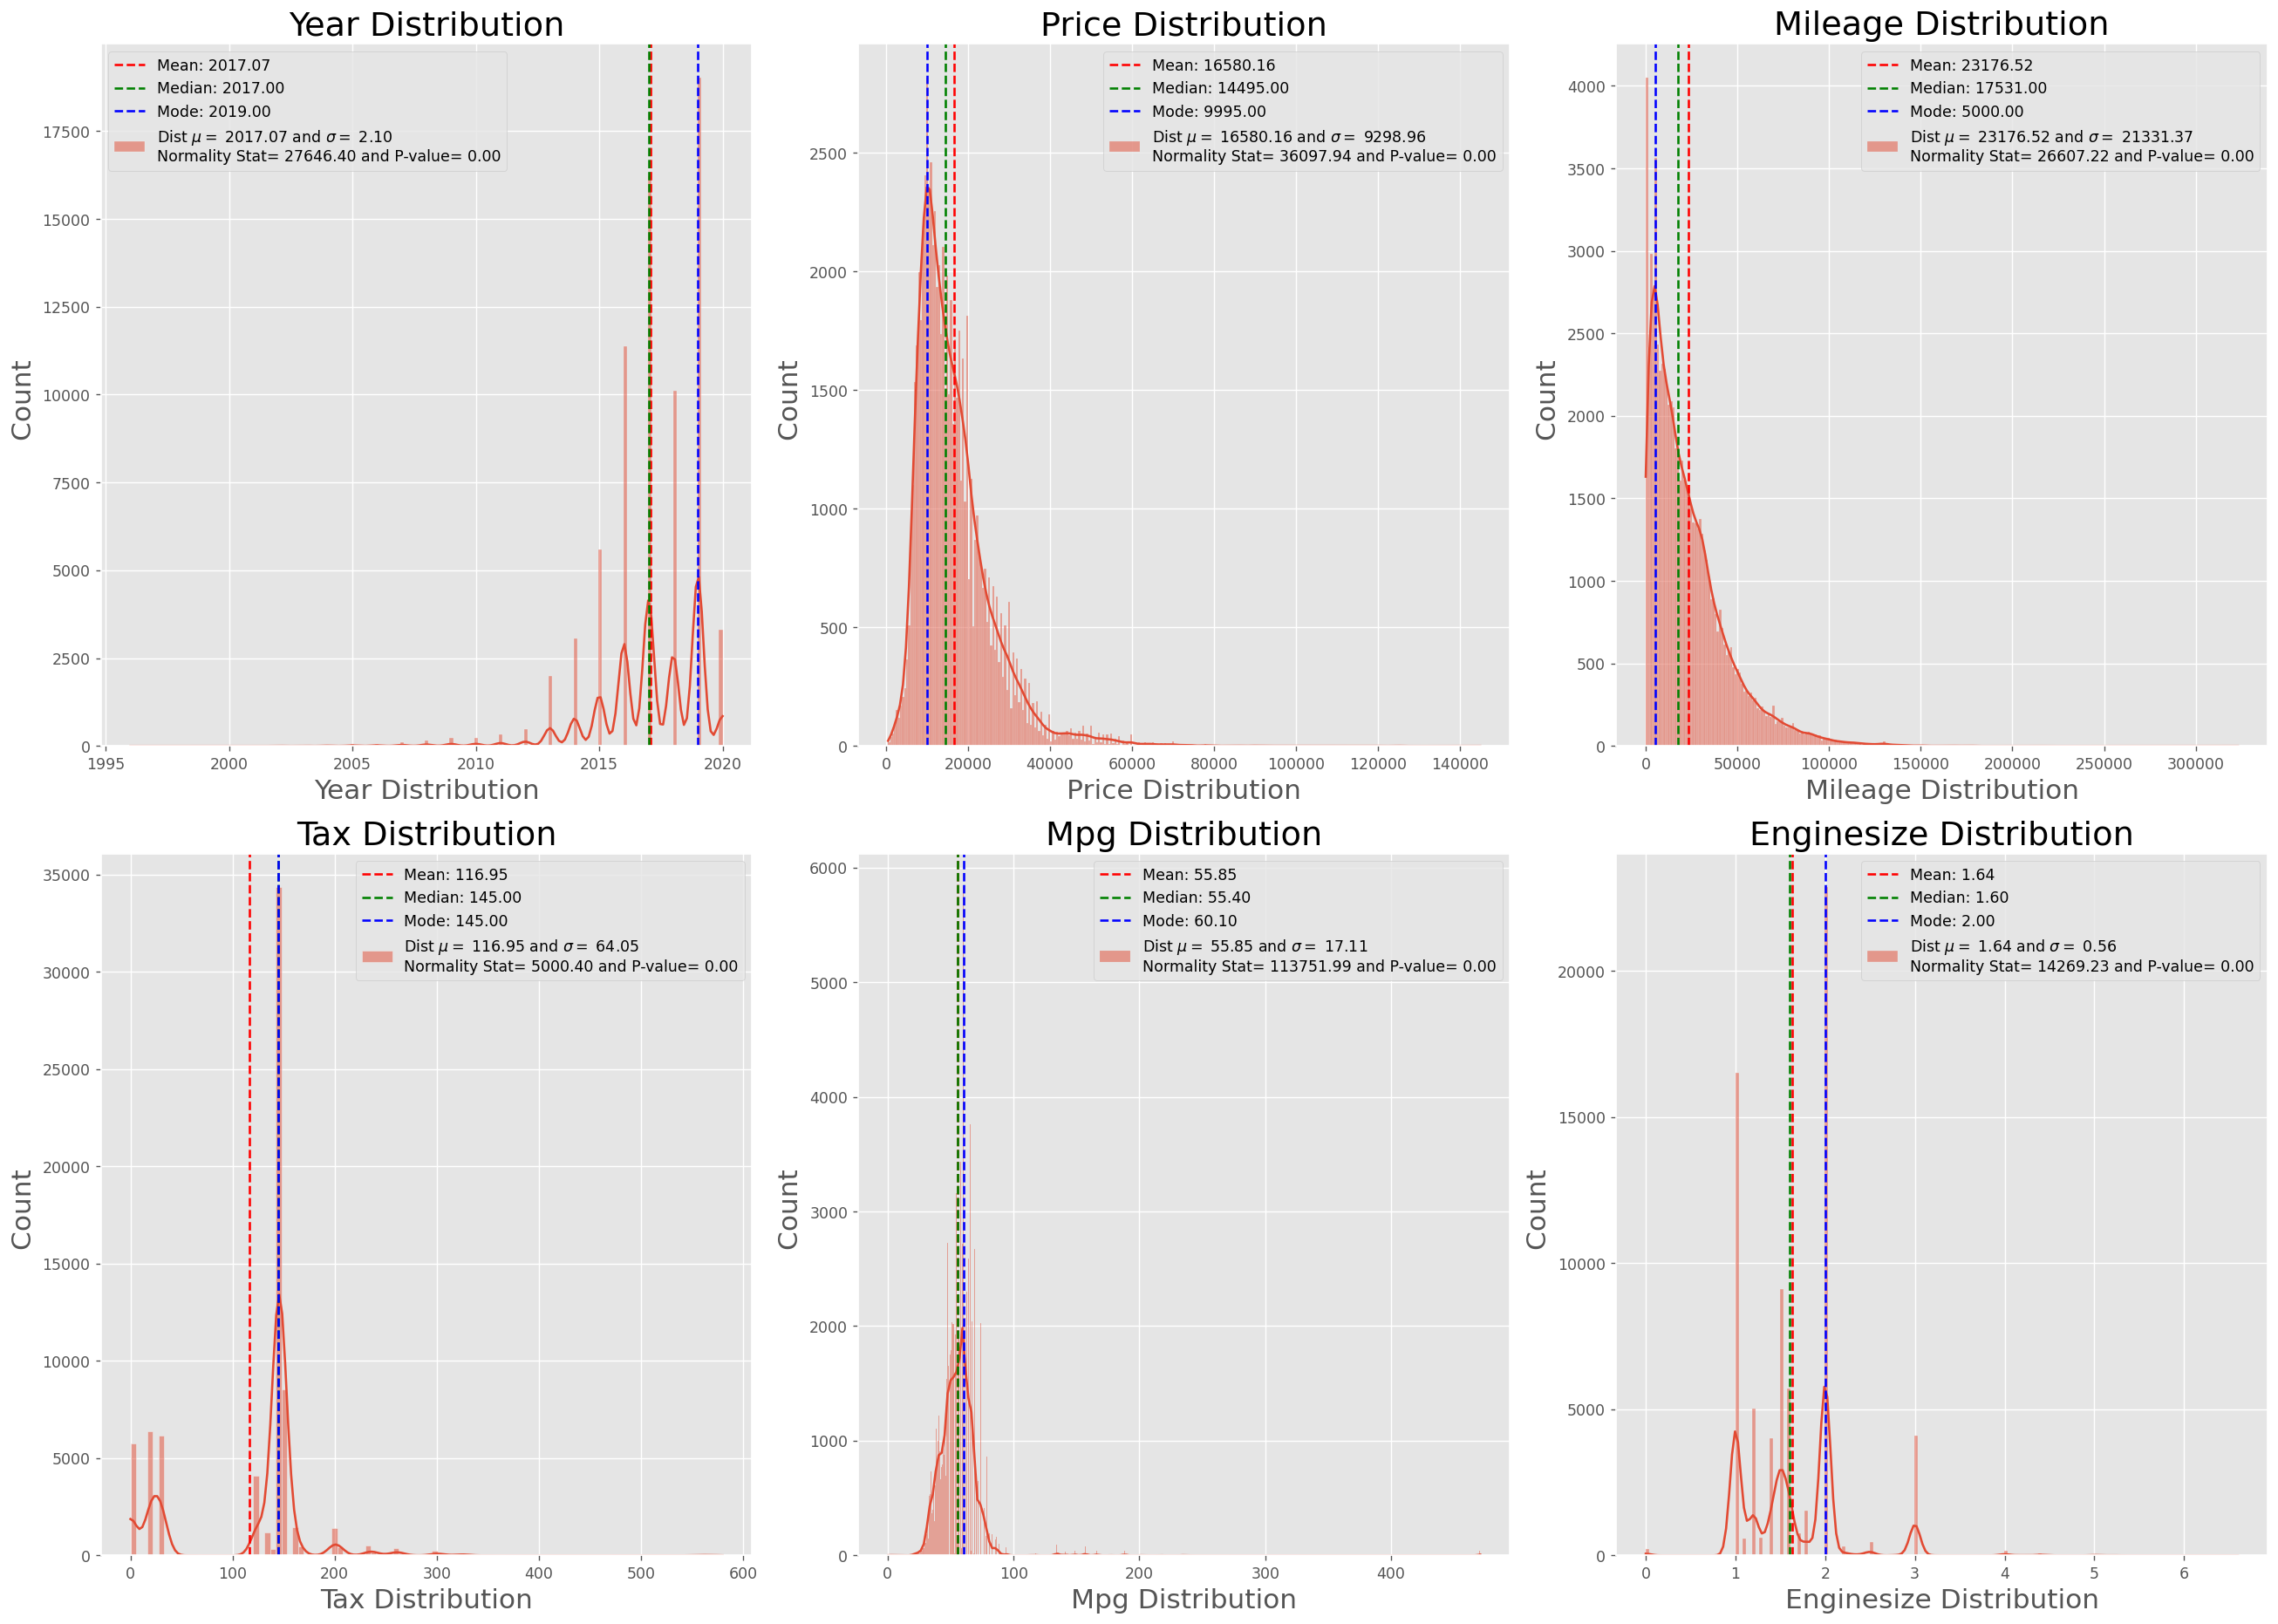

In [26]:
col_names=[i for i in df.select_dtypes(exclude=['object'])]
dist_graper(df,col_names,2,3)

### C) Outlier Analize

In [28]:
df,out=Outliers_Fighter(df.select_dtypes(include=['number']).columns,df,cut_level=3)
out

,year,price,mileage,tax,mpg,engineSize
Lower Bound:,2010.77,-11316.73,-40817.59,-75.18,4.51,-0.05
Upper Bound,2023.38,44477.05,87170.62,309.09,107.2,3.32
Identified lowest outliers,945,0,0,0,15,0
Identified upper outliers,0,1323,1247,257,447,341
Total outlier observations,945,1323,1247,257,462,341
Non-outlier observations:,71490,71112,71188,72178,71973,72094
Total percentual of Outliers,0.0132,0.0186,0.0175,0.0036,0.0064,0.0047


## Data Preprosses

In [120]:
dfv1=df.copy()

### A) Data Manipulation

In [121]:
dfv1=manipulator(dfv1)

### B) Data Scaling and Encode

In [122]:
le=MultiColumnLabelEncoder(columns=[i for i in df.columns if i!='price' and i != 'mileage'])
dfv1=le.fit_transform(dfv1)
sc=MultiColumnScaler(columns=['price','mileage'])
dfv1=sc.fit_transform(dfv1)


### C) Modeling for Nan

In [123]:
x_val=dfv1[dfv1.engineSize==0]
x=dfv1[dfv1.engineSize!=0].drop('engineSize',axis=1)
y=dfv1[dfv1.engineSize!=0]['engineSize']
x_tr,x_ts,y_tr,y_ts=train_test_split(x,y,test_size=0.25,random_state=42)

In [124]:
models = [LogisticRegression(),SGDClassifier(),PassiveAggressiveClassifier(),
          KNeighborsClassifier(),DecisionTreeClassifier(),HistGradientBoostingClassifier(),
          GradientBoostingClassifier(),RandomForestClassifier(),LGBMClassifier(verbose=-1),CatBoostClassifier(verbose=False)]

factory=model_factory(x_tr,x_ts,y_tr,y_ts,models)
factory.fit_and_pred(accuracy_score)
result=factory.get_result_df()
result



,Model,Score
0,LogisticRegression,0.510269
1,PassiveAggressiveClassifier,0.520119
2,SGDClassifier,0.531703
3,GradientBoostingClassifier,0.901393
4,LGBMClassifier,0.907549
5,DecisionTreeClassifier,0.948122
6,HistGradientBoostingClassifier,0.950249
7,KNeighborsClassifier,0.958252
8,CatBoostClassifier,0.963680
9,RandomForestClassifier,0.967374


In [83]:
reg = RandomForestClassifier(random_state=240)
reg.fit(x_tr, y_tr)
y_pr = reg.predict(x_ts)
print(classification_report(y_ts,y_pr))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      4070
           2       0.96      0.97      0.96      1576
           3       0.95      0.95      0.95      1046
           4       0.97      0.96      0.96      2338
           5       0.96      0.94      0.95      1402
           6       0.97      0.96      0.97       362
           7       0.99      0.99      0.99       201
           8       0.96      0.98      0.97      5692
           9       0.96      0.94      0.95       250
          10       0.96      0.94      0.95       885
          11       0.97      0.81      0.88        47

    accuracy                           0.97     17869
   macro avg       0.97      0.95      0.96     17869
weighted avg       0.97      0.97      0.97     17869



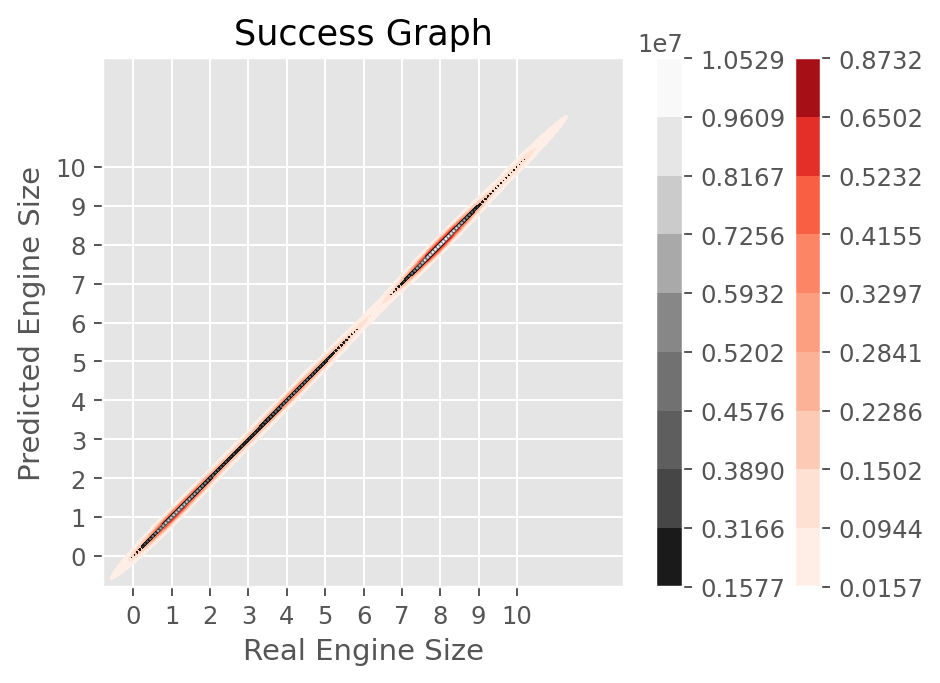

In [84]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=175)
plt.title('Success Graph')

sns.kdeplot(x=y_ts, y=y_pr.ravel(), cmap="Reds", shade=True, cbar=True, ax=ax)
sns.kdeplot(x=y_ts, y=y_ts, cmap="Greys_r", shade=True, cbar=True, ax=ax)
plt.ylabel('Predicted Engine Size')
plt.xlabel('Real Engine Size')
plt.xticks(range(0, 11))
plt.yticks(range(0, 11))

plt.show()

### --- Save the model and the cleand data ---

In [85]:
joblib.dump(reg,'inputer_size.pkl')

['inputer_size.pkl']

In [86]:
reg=joblib.load('inputer_size.pkl')
non_zero=reg.predict(x_val.drop('engineSize',axis=1))
dfv1.loc[dfv1.engineSize==0,'engineSize']=non_zero

In [87]:
dfv1=le.inverse_transform(dfv1)
dfv1=sc.inverse_transform(dfv1)

In [88]:
dfv1.to_csv('cars_ok.csv',index_label=False)

## Modeling

In [268]:
dfv1=pd.read_csv('cars_ok.csv')
x=dfv1.drop('price',axis=1)
y=dfv1['price']
x_tr,x_ts,y_tr,y_ts=train_test_split(x,y,test_size=0.25,random_state=42)

### A) Find Best Method

In [222]:
cat_col=df_cat.Name.to_list()
num_col=df_num.Name.drop(1).to_list()
way=find_best_way(cat_col,num_col,x,y,x_tr,y_tr)
way.lay_the_pipeline(CatBoostRegressor(verbose=0),      RobustScaler(), ce.CatBoostEncoder(cols=cat_col))
way.lay_the_pipeline(CatBoostRegressor(verbose=0),      MinMaxScaler(), ce.CatBoostEncoder(cols=cat_col))
way.lay_the_pipeline(RandomForestRegressor(n_jobs=-1),  RobustScaler(), ce.BaseNEncoder(cols=cat_col))
way.lay_the_pipeline(RandomForestRegressor(n_jobs=-1),  MinMaxScaler(), ce.LeaveOneOutEncoder (cols=cat_col))
way.lay_the_pipeline(CatBoostRegressor(verbose=0),      RobustScaler(), ce.JamesSteinEncoder(cols=cat_col))
way.lay_the_pipeline(CatBoostRegressor(verbose=0),      RobustScaler(), ce.JamesSteinEncoder(cols=cat_col))
way.lay_the_pipeline(RandomForestRegressor(n_jobs=-1),  MinMaxScaler(), ce.LeaveOneOutEncoder (cols=cat_col))
way.lay_the_pipeline(RandomForestRegressor(n_jobs=-1),  RobustScaler(), ce.BaseNEncoder(cols=cat_col))
way.get_result_df()

,Model,Scaler,Encoder,Mae,MaeStd
0,CatBoostRegressor,RobustScaler,JamesSteinEncoder,3396.890,1568.432
1,CatBoostRegressor,RobustScaler,JamesSteinEncoder,3396.890,1568.432
2,RandomForestRegressor,RobustScaler,BaseNEncoder,3473.239,1448.902
3,RandomForestRegressor,RobustScaler,BaseNEncoder,3475.139,1437.909
4,CatBoostRegressor,MinMaxScaler,CatBoostEncoder,3602.237,1391.580
5,CatBoostRegressor,RobustScaler,CatBoostEncoder,3602.270,1391.556
6,RandomForestRegressor,MinMaxScaler,LeaveOneOutEncoder,6837.306,1627.608
7,RandomForestRegressor,MinMaxScaler,LeaveOneOutEncoder,6848.187,1639.590


In [239]:
scaler=RobustScaler()
encoder=ce.JamesSteinEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)
preprocessor = ColumnTransformer(
    transformers = [('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)],
                    n_jobs=-1
    
)

x=preprocessor.fit_transform(x,y)

In [240]:
x_tr,x_ts,y_tr,y_ts=train_test_split(x,y,test_size=0.25,random_state=42)

rf=RandomForestRegressor(n_estimators=200,random_state=240,n_jobs=-1)
rf.fit(x_tr,y_tr)
rf_y_pr=rf.predict(x_ts)
rf_score=np.round(mean_squared_error(y_ts,rf_y_pr,squared=False),3)

cat=CatBoostRegressor(verbose=0)
cat.fit(x_tr,y_tr,eval_set=(x_ts,y_ts),verbose=False,early_stopping_rounds=100)
cat_y_pr=cat.predict(x_ts)
cat_score=np.round(mean_squared_error(y_ts,cat_y_pr,squared=False),3)

### B) Model Evaluation

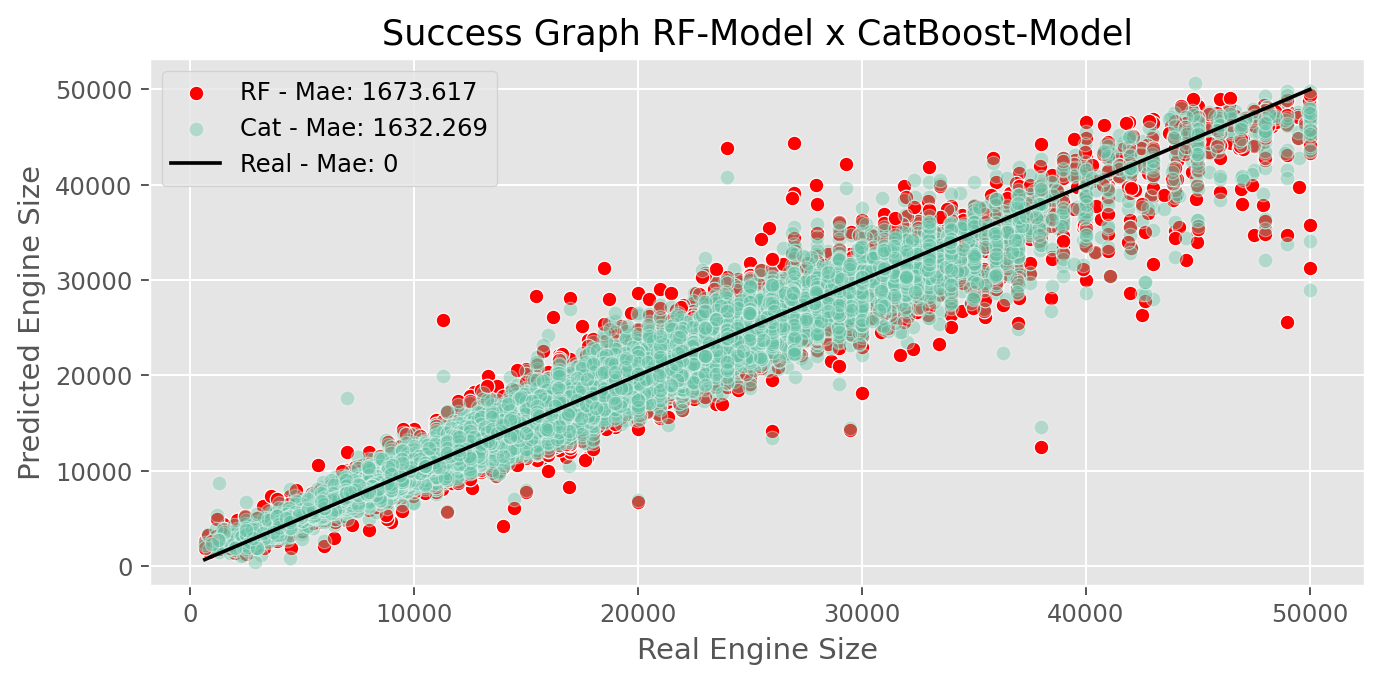

In [247]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=175)
plt.title('Success Graph RF-Model x CatBoost-Model')

sns.scatterplot(x=y_ts, y=rf_y_pr.ravel(), color="red", ax=ax,label=f'RF - Mae: {rf_score}')
sns.scatterplot(x=y_ts, y=cat_y_pr.ravel(), color=sns.color_palette("Set2")[0], ax=ax,label=f'Cat - Mae: {cat_score}',alpha=0.4)
sns.lineplot(x=y_ts, y=y_ts, color="black", ax=ax,label='Real - Mae: 0')
plt.legend(loc='upper left')
plt.ylabel('Predicted Engine Size')
plt.xlabel('Real Engine Size')


plt.tight_layout()
plt.show()

In [249]:
def optimize(trial):
    rf_w = trial.suggest_float('rf_w', 0, 1)
    cb_w = trial.suggest_float('cb_w', 0, 1)
    
    y_pr = (rf.predict(x_ts) * rf_w + cat.predict(x_ts) * cb_w)
    mae = np.sqrt(mean_squared_error(y_pr, y_ts,squared=False))
    
    return mae, rf_w, cb_w


study = optuna.create_study(direction='minimize')
progress_bar = tqdm(total=100, desc='Optimizing', position=0)

def optimize_with_progress_bar(trial):
    result = optimize(trial)
    progress_bar.update(1)
    return result[0]

study.optimize(optimize_with_progress_bar, n_trials=100)



[I 2023-12-11 12:45:45,666] A new study created in memory with name: no-name-e511bed6-afc7-4c64-8c4b-ac0ab55f4955
Optimizing: 100%|██████████| 100/100 [00:31<00:00,  3.32it/s][I 2023-12-11 12:46:17,080] Trial 99 finished with value: 54.581392196197015 and parameters: {'rf_w': 0.4519413004578474, 'cb_w': 0.4089296998727553}. Best is trial 86 with value: 39.78670779482742.


In [250]:
study.best_params, study.best_value

({'rf_w': 0.5359787215932982, 'cb_w': 0.4639226795307424}, 39.78670779482742)

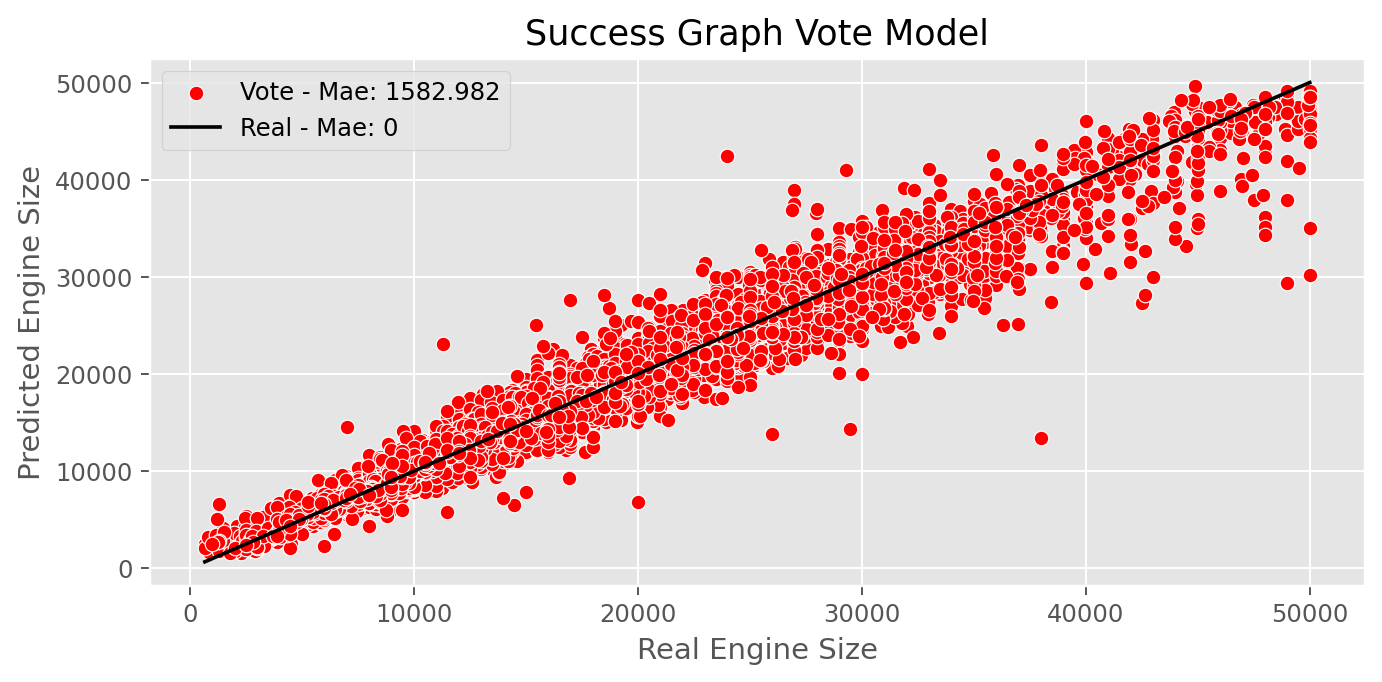

In [252]:
rf_w=0.5359787215932982
cb_w=0.4639226795307424
y_pr=(rf.predict(x_ts)*rf_w+cat.predict(x_ts)*cb_w)
vote_score=np.round(mean_squared_error(y_ts,y_pr,squared=False),3)

fig, ax = plt.subplots(figsize=(8, 4), dpi=175)
plt.title('Success Graph Vote Model')

sns.scatterplot(x=y_ts, y=y_pr.ravel(), color="red", ax=ax,label=f'Vote - Mae: {vote_score}')
sns.lineplot(x=y_ts, y=y_ts, color="black", ax=ax,label='Real - Mae: 0')
plt.legend(loc='upper left')
plt.ylabel('Predicted Engine Size')
plt.xlabel('Real Engine Size')


plt.tight_layout()
plt.show()

### C) Save The Model

In [253]:
joblib.dump(rf,'rf.pkl')
joblib.dump(cat,'cat.pkl')
joblib.dump({'rf_w': rf_w, 'cb_w': cb_w}, 'weights.pkl')

['weights.pkl']

##  Analysis of the effects of variables influencing car prices in our dataset. 

### --- Load Final Model ---

In [254]:
rf=joblib.load('rf.pkl')
cat=joblib.load('cat.pkl')
weights=joblib.load('weights.pkl')

In [259]:
scaler=RobustScaler()
encoder=ce.JamesSteinEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)
preprocessor = ColumnTransformer(
    transformers = [('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)],
                    n_jobs=-1
    
)

rf_w=weights['rf_w']
cbt_w=weights['cb_w']

voting_model=VotingRegressor(
    estimators=[
        ('rf',rf),
        ('cat',cat)],
        weights=[rf_w,cbt_w]
)

pipe=make_pipeline(preprocessor,voting_model)

In [ ]:
le=MultiColumnLabelEncoder(columns=[i for i in df.columns if i!='price' and i != 'mileage'])
dfv1=le.fit_transform(dfv1)
sc=MultiColumnScaler(columns=['price','mileage'])
dfv1=sc.fit_transform(dfv1)


In [260]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['year', 'mileage', 'tax',
                                                   'mpg', 'engineSize']),
                                                 ('cat',
                                                  Pipeline(steps=[('jamessteinencoder',
                                                                   JamesSteinEncoder(cols=['model',
                                                                                           'transmission',
                                                                                           'fuelType',
                                                                                           'Make']))]),
                                                  ['model', 'transmission',
                                                   'fuelType', 'Make'])])),
                ('votingregressor',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(n_estimators=200,
                                                                    n_jobs=-1,
                                                                    random_state=240)),
                                             ('cat',
                                              <catboost.core.CatBoostRegressor object at 0x000001ACD7F76BC0>)],
                                 weights=[0.5359787215932982,
                                          0.4639226795307424]))])

In [270]:
dfv1=pd.read_csv('cars_ok.csv')
x=dfv1.drop('price',axis=1)
y=dfv1['price']

### The Effects of Variables

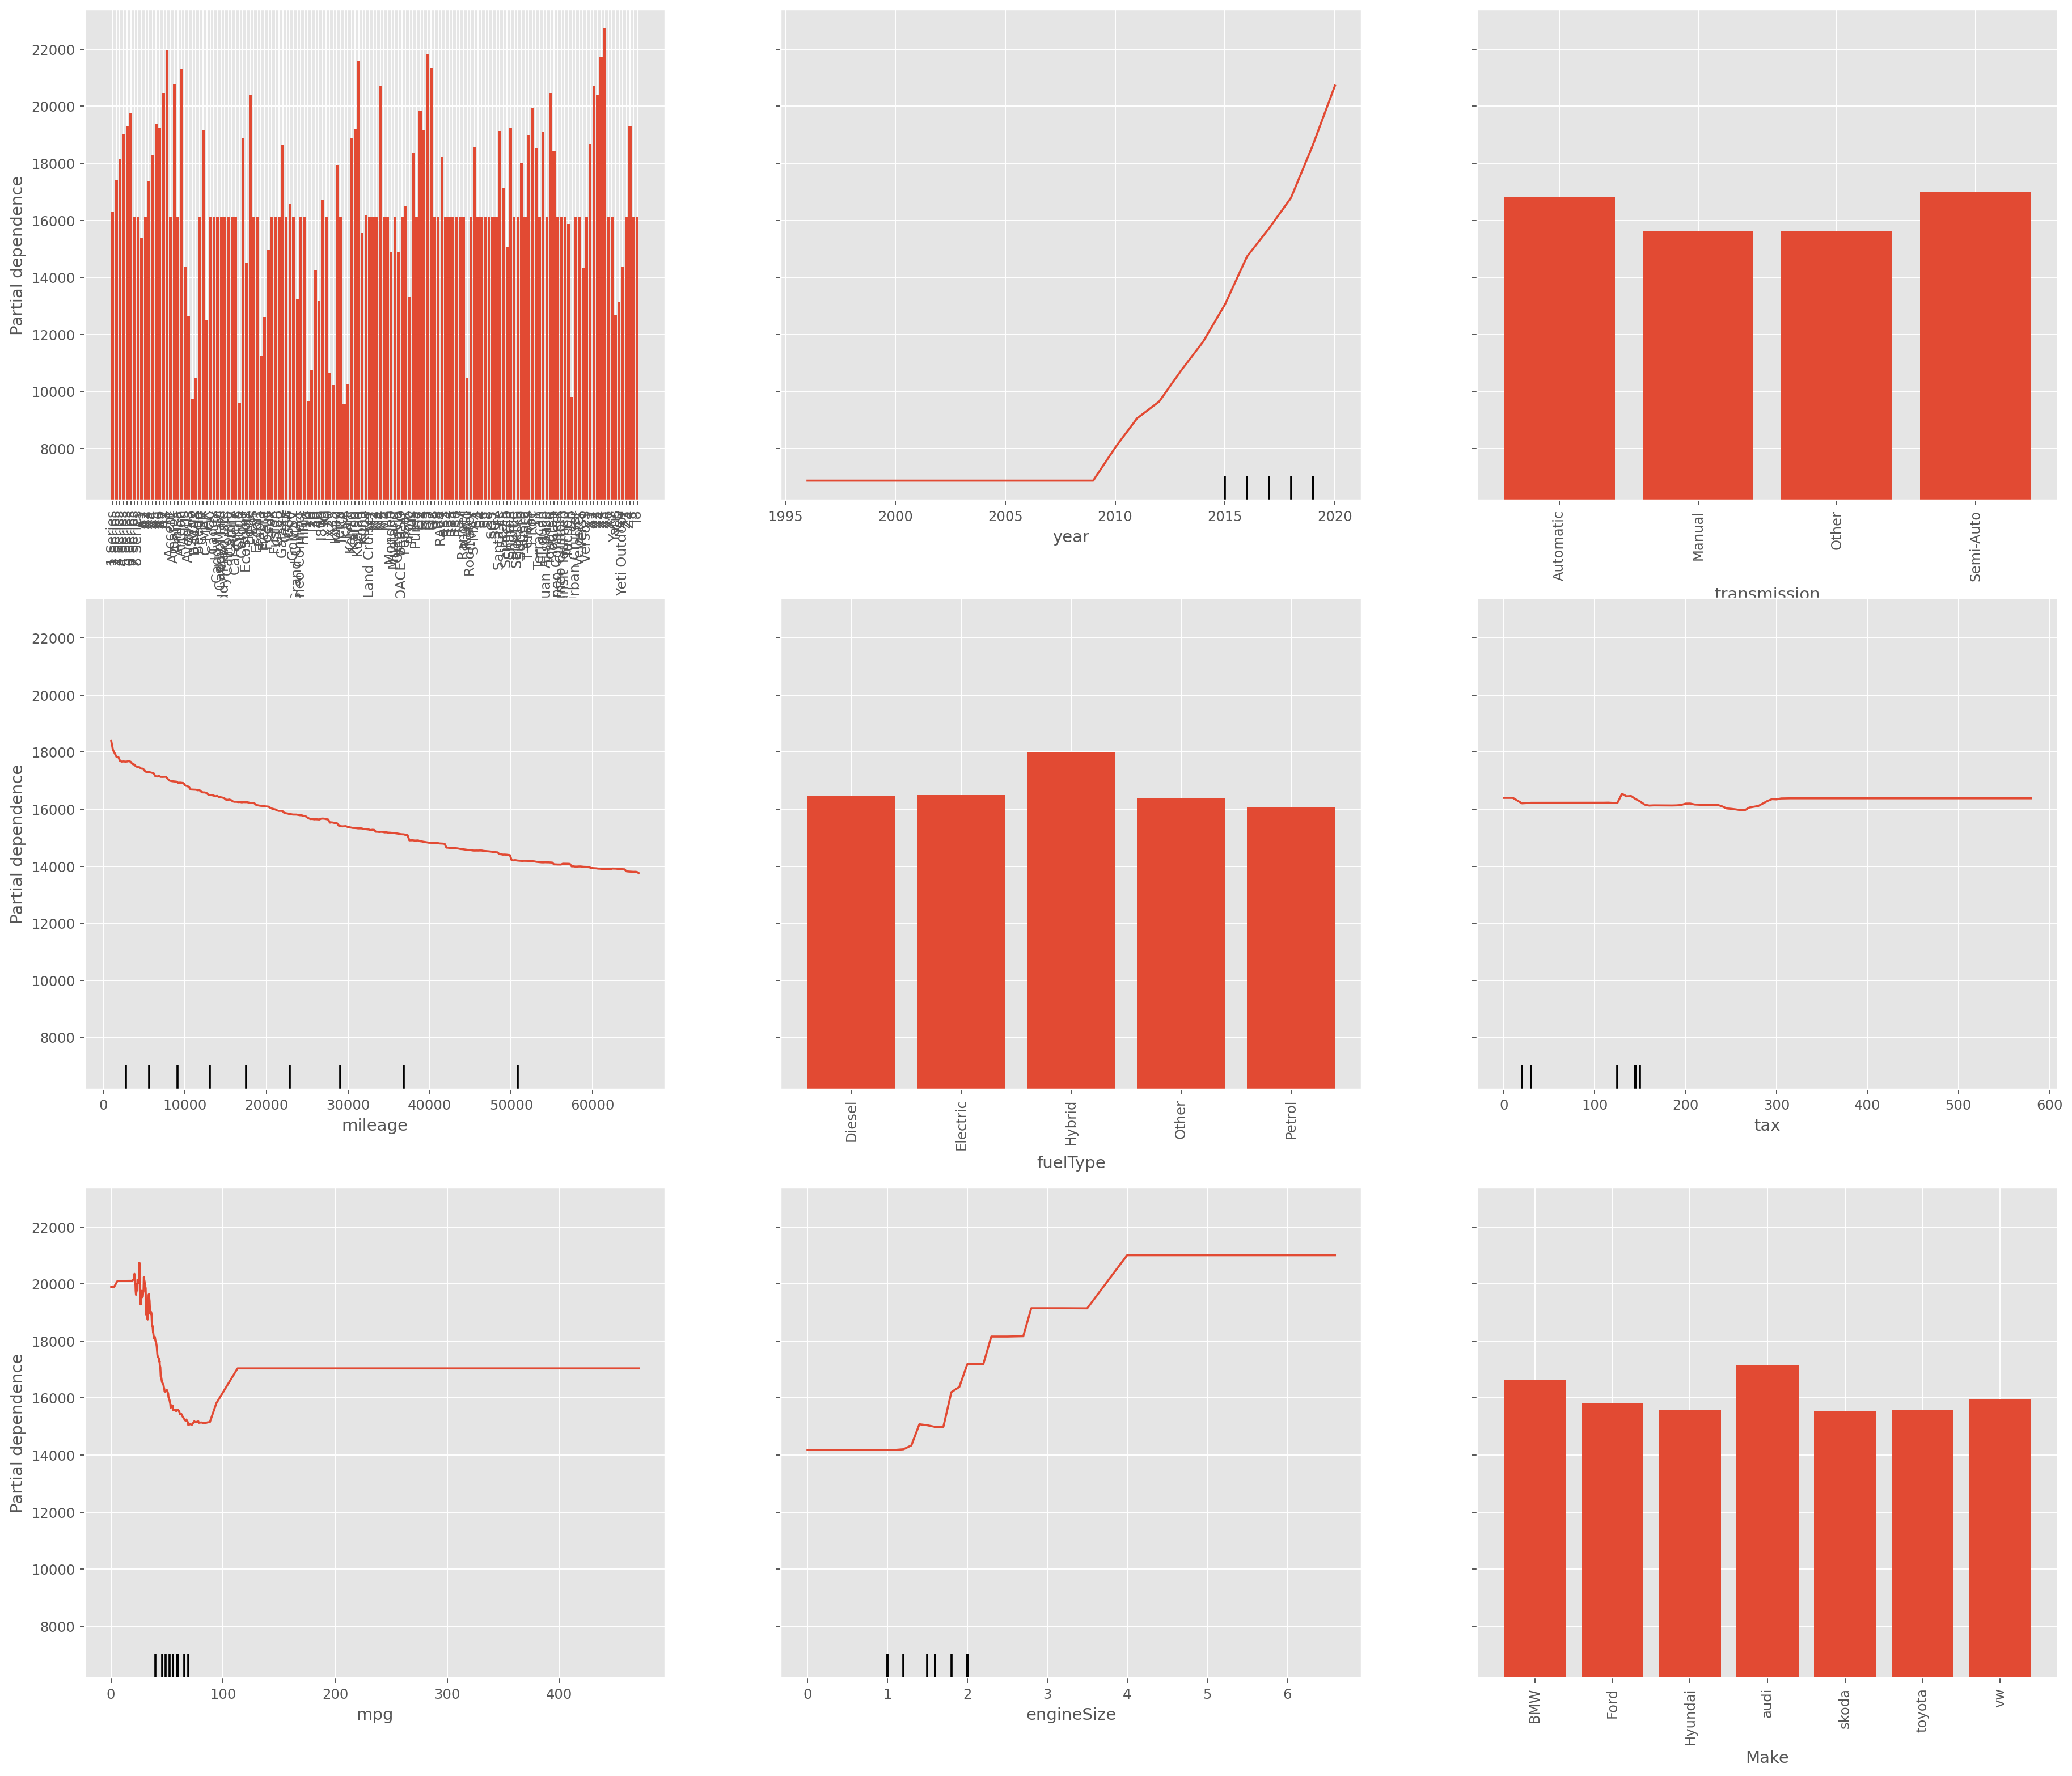

In [271]:
pdp_graper(pipe.fit(x,y),df,x.columns,['model','transmission','fuelType','Make'],18,21,dpi=175)